In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import random

In [3]:
df = pd.read_csv('/kaggle/input/mouse-behaviour/Mouse_data.csv')

In [4]:
df.head()

,timestamp,x,y,isClick,isConfused
0,50,0,0,0,0
1,100,0,0,0,0
2,150,0,0,0,0
3,200,0,0,0,0
4,250,0,0,0,0


# Feature engineering

In [5]:
def calculate_angle(x1, y1, x2, y2, x3, y3):
    v1 = [x2 - x1, y2 - y1]
    v2 = [x3 - x2, y3 - y2]
    dot = v1[0]*v2[0] + v1[1]*v2[1]
    mag1 = np.sqrt(v1[0]**2 + v1[1]**2)
    mag2 = np.sqrt(v2[0]**2 + v2[1]**2)
    
    if mag1 == 0 or mag2 == 0:
        return 0.0

    cos_theta = np.clip(dot / (mag1 * mag2), -1.0, 1.0)
    angle = np.degrees(np.arccos(cos_theta))
    return angle

In [6]:
def label_angle(angle):
    if np.isnan(angle):   
        return 0
    if angle < 30:
        return 0
    elif angle < 60:
        return 1
    elif angle < 90:
        return 2
    elif angle < 120:
        return 3
    elif angle < 150:
        return 4
    else:
        return 5

In [7]:
def extract_features(extracted, time_diff=0.05):

    
    # 1. Initialize new columns
    extracted['distance_covered'] = 0.0
    extracted['idle_time'] = 0.0

    # 2. Initialize path tracking variables
    path_accumulator = 0.0


    # 3. Loop through data
    
    for i in range(1, len(extracted)):
        
        # Distance between two points
        dx = extracted.loc[i, 'x'] - extracted.loc[i-1, 'x']
        dy = extracted.loc[i, 'y'] - extracted.loc[i-1, 'y']
        distance = np.sqrt(dx**2 + dy**2)
        extracted.loc[i, 'distance_covered'] = distance

        # Idle time
        if extracted.loc[i, 'x'] == extracted.loc[i-1, 'x'] and extracted.loc[i, 'y'] == extracted.loc[i-1, 'y']:
            extracted.loc[i, 'idle_time'] = extracted.loc[i-1, 'idle_time'] + time_diff
        else:
            extracted.loc[i, 'idle_time'] = 0.0



    # 4. Cursor speed
    extracted['cursor_speed'] = extracted['distance_covered'] / time_diff
    # 5. Acceleration
    extracted['acceleration'] = extracted['cursor_speed'] / time_diff
    # 6. Movement angles
    angles = []
    for i in range(1, len(extracted) - 1):
        angle = calculate_angle(
            extracted.loc[i-1, 'x'], extracted.loc[i-1, 'y'],
            extracted.loc[i, 'x'], extracted.loc[i, 'y'],
            extracted.loc[i+1, 'x'], extracted.loc[i+1, 'y']
        )
        angles.append(angle)

    # Drop first and last row (lost after angle calculation)
    extracted = extracted.iloc[1:-1].copy()
    extracted['movement_angle'] = angles
    extracted['prev_movement_angle'] = [0] + angles[1:] 

    # 7. Label angles
    extracted['angle_label'] = extracted['movement_angle'].apply(label_angle)
    # 8. prev angle label

    extracted['prev_angle_label'] = extracted['prev_movement_angle'].apply(label_angle)
    return extracted

In [8]:
extracted = extract_features(df, time_diff=0.05)

In [9]:
extracted.isnull().sum()

timestamp              0
x                      0
y                      0
isClick                0
isConfused             0
distance_covered       0
idle_time              0
cursor_speed           0
acceleration           0
movement_angle         0
prev_movement_angle    0
angle_label            0
prev_angle_label       0
dtype: int64

**Precision is the ratio between the shortest distance between two correct clicks and the actual path**

**studies tell that the cursor speed gets slower on confusion and/or frustration**

to be done: normalization, splitting, model, validation, ROC, confusion, f2_score

# Preprocessing and model

In [10]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [11]:
scaler = StandardScaler()

#### movement_angle to be dropped (if needed)

In [12]:
x_train = extracted.drop('isConfused' , axis = 1)
y_train = extracted['isConfused']

In [13]:
# X_train , X_test , y_train , y_test = train_test_split(x_train , y_train , random_state = 42  , test_size = 0.2)

In [14]:
X_train , X_test , y_train , y_test = train_test_split(x_train , y_train , random_state = 42  , test_size = 0.2)

In [15]:
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.transform(X_test)

##### try with LR , randomforest , SVM

In [16]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [17]:
log_r = LogisticRegression(random_state = 42 , max_iter = 150 , verbose = 1)

In [18]:
svm = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [19]:
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    use_label_encoder=False,
    # eval_metric='logloss'  
)


In [20]:
log_r.fit(x_train_scaled , y_train)

LogisticRegression(max_iter=150, random_state=42, verbose=1)

In [21]:
svm.fit(x_train_scaled , y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [22]:

xgb.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric=['logloss', 'error'],
    verbose=True
)

results = xgb.evals_result()


[0]	validation_0-logloss:0.65030	validation_0-error:0.20640
[1]	validation_0-logloss:0.60926	validation_0-error:0.18782
[2]	validation_0-logloss:0.57010	validation_0-error:0.13829
[3]	validation_0-logloss:0.55129	validation_0-error:0.13313
[4]	validation_0-logloss:0.53742	validation_0-error:0.13416
[5]	validation_0-logloss:0.51789	validation_0-error:0.11971
[6]	validation_0-logloss:0.49127	validation_0-error:0.12074
[7]	validation_0-logloss:0.47102	validation_0-error:0.11146
[8]	validation_0-logloss:0.45169	validation_0-error:0.11455
[9]	validation_0-logloss:0.43206	validation_0-error:0.11662
[10]	validation_0-logloss:0.41537	validation_0-error:0.11971
[11]	validation_0-logloss:0.38932	validation_0-error:0.09907
[12]	validation_0-logloss:0.38066	validation_0-error:0.11042
[13]	validation_0-logloss:0.37086	validation_0-error:0.09494
[14]	validation_0-logloss:0.35790	validation_0-error:0.08772
[15]	validation_0-logloss:0.34154	validation_0-error:0.07430
[16]	validation_0-logloss:0.33558	

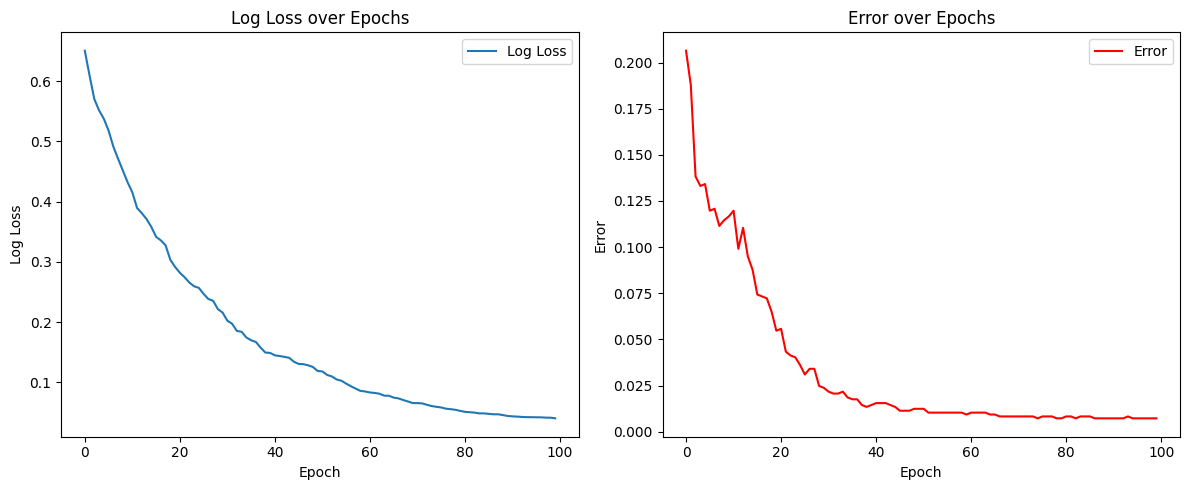

In [23]:
import matplotlib.pyplot as plt

epochs = len(results['validation_0']['logloss'])
x_axis = range(epochs)

plt.figure(figsize=(12, 5))

# Log Loss
plt.subplot(1, 2, 1)
plt.plot(x_axis, results['validation_0']['logloss'], label='Log Loss')
plt.title('Log Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.legend()

# Error (1 - Accuracy)
plt.subplot(1, 2, 2)
plt.plot(x_axis, results['validation_0']['error'], label='Error', color='red')
plt.title('Error over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Error')
plt.legend()

plt.tight_layout()
plt.show()


# Evaluation

In [24]:
log_r.score(x_test_scaled , y_test )

0.6842105263157895

In [25]:
svm.score(x_test_scaled , y_test )

0.7079463364293086

In [26]:
xgb.score(X_test , y_test )

0.9927760577915377

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Confusion matrix

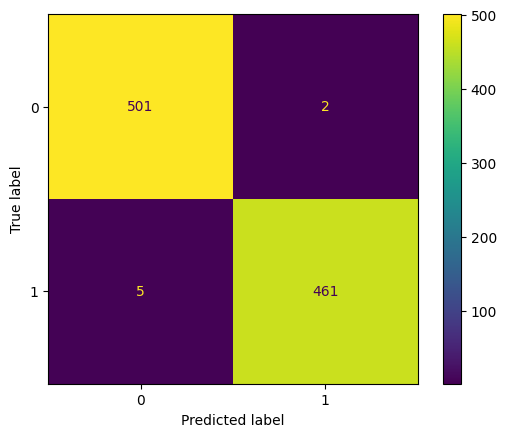

In [28]:
y_pred_probs = xgb.predict(X_test)

y_pred = (y_pred_probs > 0.5).astype(int)  

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

## F2_score

In [29]:
from sklearn.metrics import fbeta_score

f2 = fbeta_score(y_test, y_pred, beta=2)
print("F2 Score:", f2)

F2 Score: 0.9905457670820799


## ROC Curve

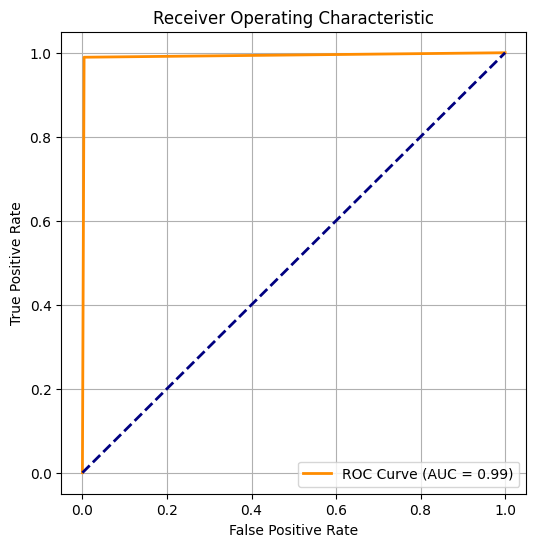

In [30]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get FPR, TPR for different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)

# Calculate AUC
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC Curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [31]:
xgb.save_model('xgb-99%.json')

In [32]:
xgb.save_model('xgb-99%.pkl')

In [33]:
xgb.save_model("xgb_confusion_detector.model")

#### playground

In [34]:
pip freeze > requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [35]:
!python --version


Python 3.11.11
